# Chapter 3 - Classification Code Reproduction

In [ ]:
# Impor umum
import numpy as np
import os

# Untuk membuat plot yang konsisten
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Untuk menyimpan gambar
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
Bentuk data (X): (70000, 784)
Bentuk label (y): (70000,)


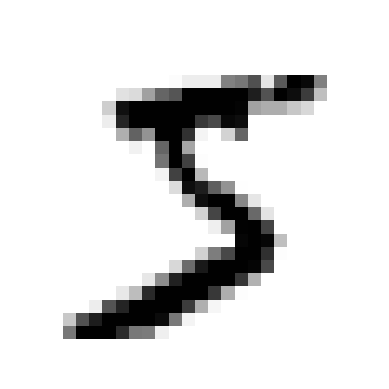

Label untuk gambar di atas: 5


In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())

# Memisahkan data dan label
X, y = mnist["data"], mnist["target"]
print("Bentuk data (X):", X.shape)
print("Bentuk label (y):", y.shape)

# Mengubah tipe data label menjadi integer
y = y.astype(np.uint8)

# Menampilkan salah satu digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print("Label untuk gambar di atas:", y[0])

# Memisahkan data menjadi training set dan test set
# MNIST sudah terbagi, 60,000 pertama untuk train, 10,000 terakhir untuk test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
# Membuat label target: True untuk 5, False untuk lainnya
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# Menginisialisasi dan melatih SGD Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Melakukan prediksi pada satu digit
print("Prediksi untuk digit pertama (seharusnya 5):", sgd_clf.predict([some_digit]))

Prediksi untuk digit pertama (seharusnya 5): [ True]


In [ ]:
from sklearn.model_selection import cross_val_score

# Mengevaluasi SGDClassifier menggunakan K-fold cross-validation
scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("Skor akurasi cross-validation:", scores)

# Membuat classifier bodoh yang selalu menebak "bukan-5"
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
never_5_scores = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print("Skor akurasi 'Never5Classifier':", never_5_scores)
# HASIL: Akurasi > 90%, menunjukkan akurasi bukan metrik yang baik untuk skewed dataset

Skor akurasi cross-validation: [0.95035 0.96035 0.9604 ]
Skor akurasi 'Never5Classifier': [0.91125 0.90855 0.90915]


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Mendapatkan prediksi untuk setiap instance di training set
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Membuat matriks konfusi
cm = confusion_matrix(y_train_5, y_train_pred)
print("Matriks Konfusi:\n", cm)
# HASIL:
# [[TN, FP],
#  [FN, TP]]

# Matriks konfusi ideal (jika prediksi sempurna)
y_train_perfect_predictions = y_train_5
cm_perfect = confusion_matrix(y_train_5, y_train_perfect_predictions)
print("\nMatriks Konfusi Ideal:\n", cm_perfect)

Matriks Konfusi:
 [[53892   687]
 [ 1891  3530]]

Matriks Konfusi Ideal:
 [[54579     0]
 [    0  5421]]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Menghitung precision dan recall dari matriks konfusi
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1 Score: 0.7325171197343847


Decision score: [2164.22030239]
Prediksi dengan threshold 0: [ True]
Prediksi dengan threshold 8000: [False]


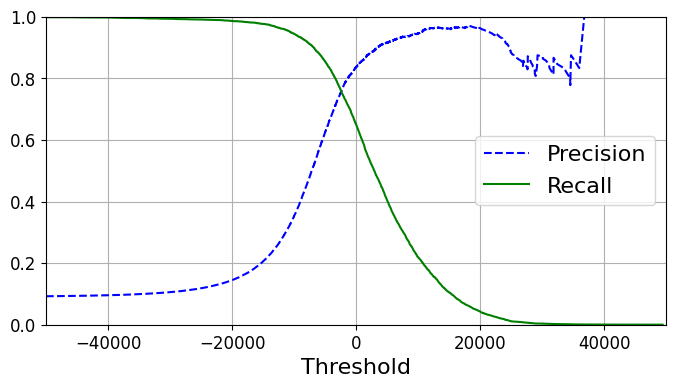

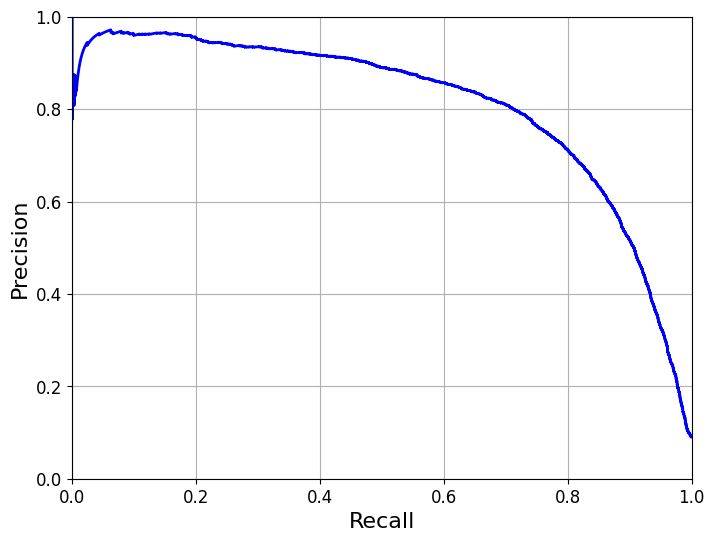


Threshold untuk 90% precision: 3370.0194991439557
Precision pada threshold baru: 0.9000345901072293
Recall pada threshold baru: 0.4799852425751706


In [ ]:
# Mendapatkan decision scores dari classifier
y_scores = sgd_clf.decision_function([some_digit])
print("Decision score:", y_scores)

# Mengatur threshold secara manual
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print("Prediksi dengan threshold 0:", y_some_digit_pred)

threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print("Prediksi dengan threshold 8000:", y_some_digit_pred)

# Mendapatkan skor untuk semua instance
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Menghitung precision dan recall untuk semua threshold yang mungkin
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Memplot Precision dan Recall vs Threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# Memplot Precision vs Recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# Menemukan threshold untuk precision 90%
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print("\nThreshold untuk 90% precision:", threshold_90_precision)

# Membuat prediksi dengan threshold baru
y_train_pred_90 = (y_scores >= threshold_90_precision)
print("Precision pada threshold baru:", precision_score(y_train_5, y_train_pred_90))
print("Recall pada threshold baru:", recall_score(y_train_5, y_train_pred_90))

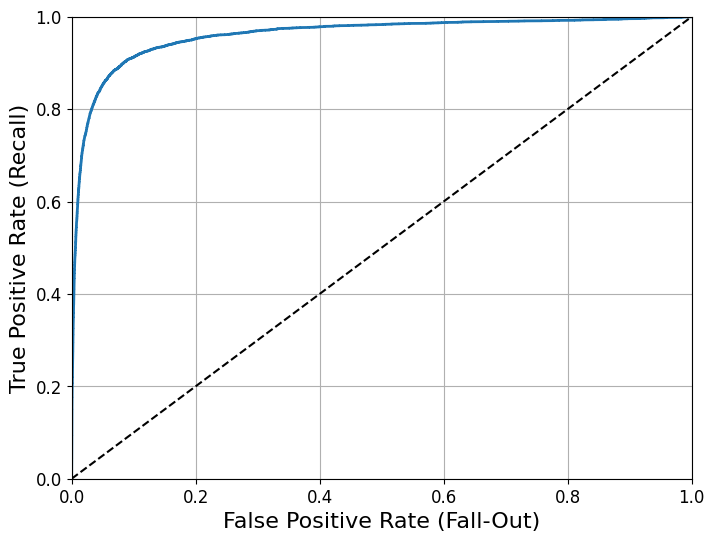


ROC AUC Score (SGD): 0.9604938554008616


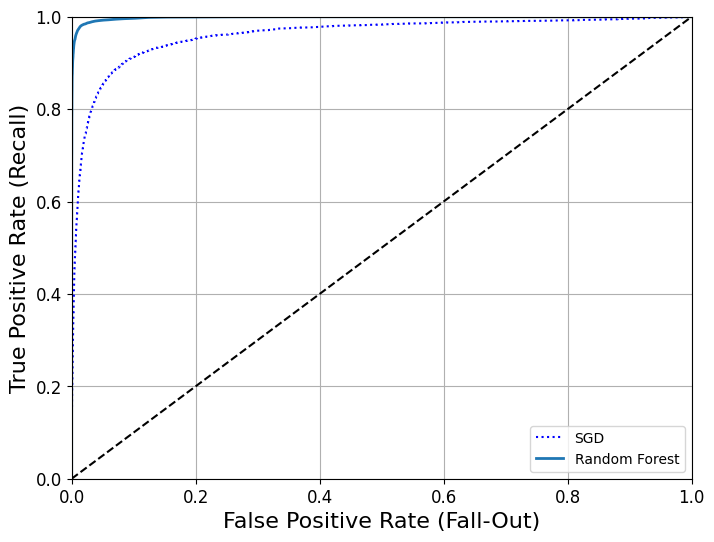

ROC AUC Score (Random Forest): 0.9983436731328145


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Menghitung TPR dan FPR untuk berbagai threshold
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Memplot kurva ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Garis classifier acak
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

# Menghitung Area Under the Curve (AUC)
auc = roc_auc_score(y_train_5, y_scores)
print("\nROC AUC Score (SGD):", auc)

# Melatih RandomForestClassifier untuk perbandingan
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# Menggunakan probabilitas kelas positif sebagai skor untuk kurva ROC
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Memplot kedua kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

print("ROC AUC Score (Random Forest):", roc_auc_score(y_train_5, y_scores_forest))

In [ ]:
from sklearn.svm import SVC

# Melatih SVC (secara otomatis menggunakan strategi One-vs-One)
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # Menggunakan label asli y_train, bukan y_train_5
print("\nPrediksi multikelas (SVM) pada digit pertama:", svm_clf.predict([some_digit]))

# Melihat decision scores (satu skor per kelas)
some_digit_scores = svm_clf.decision_function([some_digit])
print("Decision scores (SVM):\n", some_digit_scores)
print("Kelas yang diprediksi (indeks maks):", np.argmax(some_digit_scores))

# Melatih SGDClassifier pada semua kelas
sgd_clf.fit(X_train, y_train)
print("\nPrediksi multikelas (SGD) pada digit pertama:", sgd_clf.predict([some_digit]))
print("Decision scores (SGD):\n", sgd_clf.decision_function([some_digit]))

# Mengevaluasi SGDClassifier dengan cross-validation
sgd_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
print("\nSkor akurasi multikelas (SGD):", sgd_scores)

# Meningkatkan akurasi dengan scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
scaled_scores = cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")
print("Skor akurasi multikelas (SGD dengan scaling):", scaled_scores)


Prediksi multikelas (SVM) pada digit pertama: [5]
Decision scores (SVM):
 [[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
Kelas yang diprediksi (indeks maks): 5

Prediksi multikelas (SGD) pada digit pertama: [3]
Decision scores (SGD):
 [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]

Skor akurasi multikelas (SGD): [0.87365 0.85835 0.8689 ]
Skor akurasi multikelas (SGD dengan scaling): [0.8983 0.891  0.9018]



Matriks konfusi multikelas:
 [[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


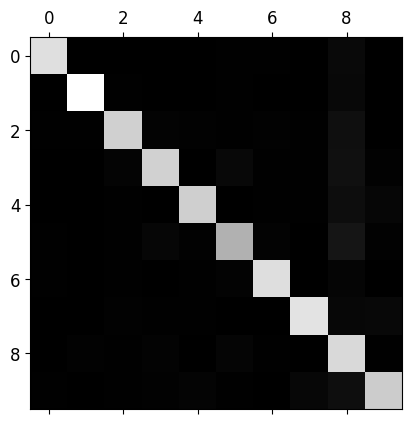

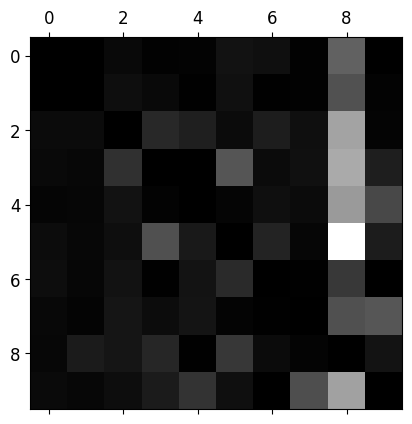

In [ ]:
# Mendapatkan prediksi untuk analisis kesalahan
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

# Membuat matriks konfusi
conf_mx = confusion_matrix(y_train, y_train_pred)
print("\nMatriks konfusi multikelas:\n", conf_mx)

# Memplot matriks konfusi sebagai gambar
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# Menormalisasi matriks konfusi untuk melihat tingkat kesalahan
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# Mengisi diagonal dengan nol untuk fokus pada kesalahan
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
# HASIL: Plot menunjukkan kesalahan klasifikasi antar digit.
# Warna terang menunjukkan kesalahan yang lebih sering terjadi.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Membuat target multilabel
y_train_large = (y_train >= 7)  # Apakah digit besar (7, 8, atau 9)?
y_train_odd = (y_train % 2 == 1) # Apakah digit ganjil?
y_multilabel = np.c_[y_train_large, y_train_odd]

# Melatih classifier multilabel
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Membuat prediksi multilabel
print("\nPrediksi multilabel pada digit pertama (angka 5):", knn_clf.predict([some_digit]))
# HASIL: [[False, True]] -> Tidak besar, tapi ganjil. Benar.

# Evaluasi classifier multilabel (contoh menggunakan F1-score makro)
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# f1_score_macro = f1_score(y_multilabel, y_train_knn_pred, average="macro")
# print("F1 Score (macro) untuk multilabel:", f1_score_macro)


Prediksi multilabel pada digit pertama (angka 5): [[False  True]]


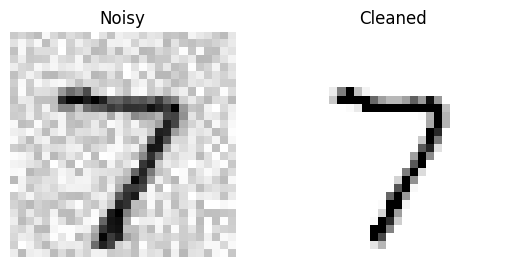

In [ ]:
# Membuat noise pada gambar MNIST
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# Target adalah gambar asli yang bersih
y_train_mod = X_train
y_test_mod = X_test

# Melatih classifier untuk membersihkan noise
knn_clf.fit(X_train_mod, y_train_mod)

# Membersihkan satu digit dan menampilkannya
clean_digit = knn_clf.predict([X_test_mod[0]])

# Fungsi untuk plot
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

# Plot gambar asli dengan noise dan gambar yang sudah dibersihkan
plt.subplot(121); plot_digit(X_test_mod[0])
plt.title("Noisy")
plt.subplot(122); plot_digit(clean_digit)
plt.title("Cleaned")
plt.show()